# Cloud Computing Exercise 6 (Trace Analysis)

This exercise is divided into two parts
1. <b>Developer Trace Analysis</b>: This part covers the trace generation, understandig of the service calls and their dependencies
2. <b>Operator Trace Analysis</b>: This part covers the analysis of traces for detection of Anomalies.

## Developer Trace Analysis

### 1. Trace Generation
1. Run the Openstack with either Redis or Jaeger trace collection
2. After the openstack has started, create an instance inside it as mentioned in the previous exercise but with the option <b>--os-profile SECRET_KEY </b>
3. Now If you have used:
<ul>
    <li>
        <b>For Redis:</b>
        <br>
            Get the HTML version of trace with the following command: 
        <br>
            <code>osprofiler trace show --connection-string redis://localhost:6379 --html <b>trace-id</b> --out trace.html</code>
    </li>
    <li>
    <b>For Jaeger: </b>
    <br>
    Go to its UI at http://VM_IP:16686 and search for that trace using the shortned trace ID
    </li>
</ul>

### 2. Trace Understanding
Now the trace has been generated, understand it carefully and answer the following questions


<b>Question 1: 
    Which project and service took most of the time for completion of the request ? </b>

Answer: <br> 
<b>Project:</b> 	
<b>Service:</b> 

<b>Question 2: What is the first request path triggered when you the Create instance is triggered ?</b>

Answer: 

Question 3: Give the sequence of the Projects being triggered (All till level 2 and including level 2)
[Add to sequence only if there is change from the previous]

Answer: 
    keystone,...

## Operator Trace Analysis
1. Here the already generated traces would be analyzed for any anomalies.
2. There are 147 total number of traces for the Volume Creation API request hosted on a MongoDB instance.
3. Out of These Traces, few of them are Anomalous and your task would be find those Anomalous traces using the method discussed below.

Look for 

##############################################################################
#    TODO    
##############################################################################

Check for the imports whether they are present on your machine or not otherwise install them using 
<code>pip install package-name</code>
   

In [2]:
##necessary imports

from pymongo import MongoClient
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from scipy.stats.distributions import norm

Connect to remote MongoDb 

In [3]:
mongoclient = MongoClient('34.90.254.95', 27017,username='ccsTraces',password='CCSTracesAnalysis54!3', authSource='traces')

Get the traces from mongodb into Pandas Dataframe and remove the fields which are not required

In [4]:
db = mongoclient['traces']
datapoints = list(db.volume_create.find({}))

In [5]:
dfMongo = json_normalize(datapoints)
dfMongo = dfMongo.drop(['children','info.name',  'stats.driver.count', 'stats.rpc.count','stats.wsgi.count','_id', 
                        'info.started' ], axis=1)
dfMongo = dfMongo[np.isfinite(dfMongo['info.finished'])]

In [6]:
dfMongo.head()

,info.last_trace_started,info.finished,stats.rpc.duration,stats.driver.duration,stats.wsgi.duration
0,1165,3825,3377,1293.0,480
1,839,1661,1188,783.0,459
2,652,1574,1308,884.0,290
3,830,1207,676,336.0,594
4,289,384,95,NaN,345


We are only focussed in this exercise for the total duration which is <b>info.finished</b>

### Histogram vs KDE
A common task in statistics is to estimate the probability density function (PDF) of a random variable 
from a set of data samples. This task is called density estimation. The most well-known tool to do this
is the histogram. A histogram is a useful tool for visualization (mainly because everyone understands it),
but doesn’t use the available data very efficiently. Kernel density estimation (KDE) is a more efficient
tool for the same task. The gaussian_kde estimator can be used to estimate the PDF of univariate as well 
as multivariate data or sklearn library can be used

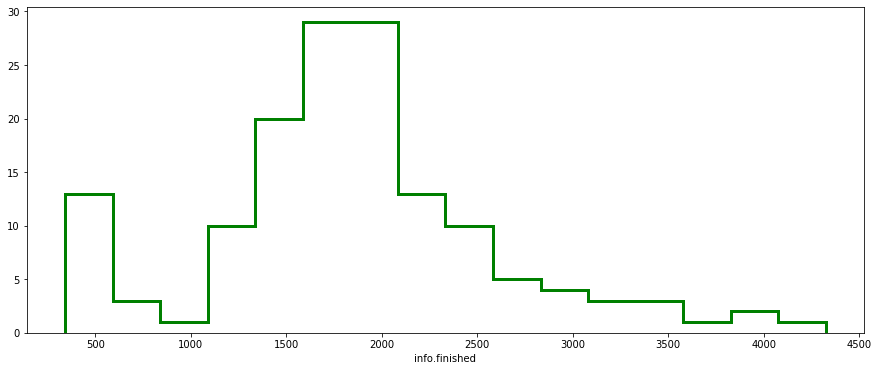

In [7]:
sns.distplot(dfMongo['info.finished'],hist=True, norm_hist=False,kde=False,
                    kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

### Forming the KDE and PDF

In [8]:
totalDurationArr = dfMongo['info.finished']

In [9]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [ kde_scipy, kde_sklearn]
kde_funcnames = [ 'Scipy', 'Scikit-learn']


Finding the best bandwidth suited for forming the KDE taken in consideration all values from 10^(-1) to 10^(3) using GridSearchCV

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 3, len(totalDurationArr))
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(totalDurationArr[:, None]);
grid.best_params_

{'bandwidth': 170.9529944234296}

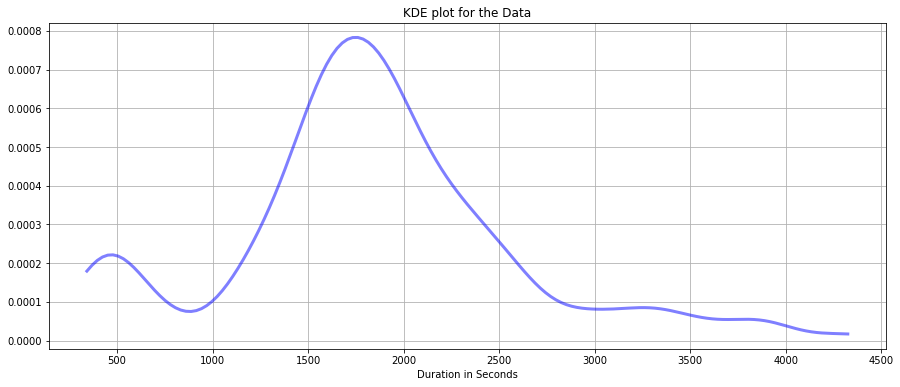

In [11]:
# The grid we'll use for plotting
totalDurationArr_grid = np.linspace(totalDurationArr.min(),totalDurationArr.max(), len(totalDurationArr))
i=0
pdf = kde_funcs[i](totalDurationArr, totalDurationArr_grid, bandwidth=grid.best_params_['bandwidth'])
plt.plot(totalDurationArr_grid, pdf, color='blue', alpha=0.5, lw=3)
plt.title("KDE plot for the Data")
plt.xlabel("Duration in Seconds")
plt.grid(True)

## Statistical analysis. 

### Z-Score
The Z-score, or standard score, is a way of describing a data point in terms of its relationship to the mean and 
standard deviation of a group of points.
The intuition behind the Z-score method of outlier detection is that, once we’ve centred and rescaled the data,
anything that is too far from zero (the threshold is usually a Z-score of 3 or -3) should be considered an outlier.

In [12]:
def outliers_z_score(ys):
    threshold = 3
##############################################################################
#    TODO
#    Calculate Z-Scores here 
##############################################################################
    mean_y = None
    stdev_y = None
    z_scores = None
    return np.where(np.abs(z_scores) > threshold), z_scores, mean_y, stdev_y

In [ ]:
aa, z_scores, mean, stdev = outliers_z_score(dfMongo['info.finished'].values)
print("Mean =", mean, "Stdev = ", stdev)
print("Total Anomalies Detected: ", len(aa[0]))
for i in range(len(aa[0])):
    print ("Index = ",aa[0][i], ",Value = ", dfMongo['info.finished'][aa[0][i]], ", Z-Score=",z_scores[aa[0][i]]  )

### Modified Z-Score
The Z-score method relies on the mean and standard deviation of a group of data to measure central tendency and dispersion.
This is troublesome, because the mean and standard deviation are highly affected by outliers – they are not robust.

Another drawback of the Z-score method is that it behaves strangely in small datasets – in fact, the Z-score method will 
never detect an outlier if the dataset has fewer than 12 items in it.

A further benefit of the modified Z-score method is that it uses the median and MAD rather than the mean and standard deviation.
The median and MAD are robust measures of central tendency and dispersion, respectively.

In [13]:
def outliers_modified_z_score(ys):
    threshold = 3
##############################################################################
#    TODO
#    Calculate Modified Z-Scores here 
##############################################################################
    median_y = None
    median_absolute_deviation_y = None
    modified_z_scores = None
    return np.where(np.abs(modified_z_scores) > threshold), modified_z_scores, median_y, median_absolute_deviation_y

In [ ]:
aa, z_scores, median, mad = outliers_modified_z_score(dfMongo['info.finished'].values)

In [ ]:
aa, z_scores, median, mad = outliers_modified_z_score(dfMongo['info.finished'].values)
print("Total Anomalies Detected: ", len(aa[0]))
print("Median =", median, "MAD = ", mad)
for i in range(len(aa[0])):
    print ("Index = ",aa[0][i], ",Value = ", dfMongo['info.finished'][aa[0][i]], ", Modified Z-Score=",z_scores[aa[0][i]]  )

### IQR method
Another robust method for labeling outliers is the IQR (interquartile range) method of outlier detection.
A box-and-whisker plot uses quartiles (points that divide the data into four groups of equal size) to plot the shape of the data. The box represents the 1st and 3rd quartiles, which are equal to the 25th and 75th percentiles. The line inside the box represents the 2nd quartile, which is the median.
The interquartile range, which gives this method of outlier detection its name, is the range between the first and the third quartiles (the edges of the box). 

In [14]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
##############################################################################
#    TODO
#    Calculate IQR here 
##############################################################################
    iqr = None
    lower_bound = None
    upper_bound = None
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [ ]:
aa = outliers_iqr(dfMongo['info.finished'].values)
print("Total Anomalies Detected: ", len(aa[0]))
for i in range(len(aa[0])):
    print ("Index = ",aa[0][i], ",Value = ", dfMongo['info.finished'][aa[0][i]] )

<b>Question : Which method was able to detect the most of the anomalus traces? </b>

## <p style="color:red">.... was able to detect most of the anomalies</p>

## Optional: Clustering using DBSCAN

Can Clustering be able to detect the Anomalies

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


X =totalDurationArr.values.reshape(-1, 1)

X = StandardScaler().fit_transform(X)


##############################################################################
#    TODO
#    Compute DBSCAN
##############################################################################


#print('Estimated number of clusters: %d' %n_clusters_ )
#print('Estimated number of noise points: %d' %n_noise_ )
#print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

In [ ]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

##############################################################################
#    TODO
#    Plot Result
##############################################################################
    
    
plt.legend()
#plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

<b>Question : Was the result of Clustering same as that of above methods?</b>

Answer: yes/No and why?